# DOV using (Hash, pm) tuple
Notebook to create DOV for the message passing networks.

Done in steps:
1. Get the # Feature dictionaries for range of nBits, Degree
2. Get the Balanced Accuracy for All entries in dict
3. Choose best radius, nBits
4. plot Error for # missing, and confusion matrix

In [1]:
import pandas as pd
import seaborn as sns
import pickle as pk
from numpy import std
import numpy as np

from rdkit.Chem import AllChem
from rdkit import DataStructs

from polyml.polyml import MultiModel

from collections import defaultdict
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score

In [2]:
# Define Features
def get_ring_size(obj, max_size=12):
    if not obj.IsInRing():
        return 0
    else:
        for i in range(max_size):
            if obj.IsInRingSize(i):
                return i
        else:
            return "max"


def bond_features_v1(bond, **kwargs):
    """ Return an integer hash representing the bond type.

    flipped : bool
        Only valid for 'v3' version, whether to swap the begin and end atom
        types

    """
    return str(
        (
            bond.GetBondType(),
            bond.GetIsConjugated(),
            bond.IsInRing(),
            sorted([bond.GetBeginAtom().GetSymbol(), bond.GetEndAtom().GetSymbol()]),
        )
    )


def atom_features_v2(atom):
    props = [
        "GetChiralTag",
        "GetDegree",
        "GetExplicitValence",
        "GetFormalCharge",
        "GetHybridization",
        "GetImplicitValence",
        "GetIsAromatic",
        "GetNoImplicit",
        "GetNumExplicitHs",
        "GetNumImplicitHs",
        "GetNumRadicalElectrons",
        "GetSymbol",
        "GetTotalDegree",
        "GetTotalNumHs",
        "GetTotalValence",
    ]

    atom_type = [getattr(atom, prop)() for prop in props]
    atom_type += [get_ring_size(atom)]

    return str(tuple(atom_type))

# Code that generates a dictionary to calculate DOV
# hashed_morgan_element: set(pm1, pm2)
def get_DOV_dict(df, radius=2, nBits=2048):
    DOV_dict = defaultdict(set)

    for i, row in df.iterrows():
        m = AllChem.MolFromSmiles(row.smiles_polymer)
        fp = AllChem.GetHashedMorganFingerprint(m, radius=radius, nBits=nBits
        )

        for key in fp.GetNonzeroElements():
            DOV_dict[key].add(row.pm)
    
    return DOV_dict

# Function that takes in a molecule and a dpm value
# gets the morgan fingerprints, and sees if that feature
# has been trained for a similar pm

def get_num_missing_features(smi, pm, dpm, DOV_dict, radius=2, nBits=2048):
    num_missing_features = 0
    
    m = AllChem.MolFromSmiles(smi)
    fp = AllChem.GetHashedMorganFingerprint(m, radius=radius, nBits=nBits)
    
    for i, key in enumerate(fp.GetNonzeroElements()):
        if key not in DOV_dict:
            num_missing_features += 1
        else:
            matching_pm = False
            for pm_loc in DOV_dict[key]:
                min_pm = pm_loc-dpm
                max_pm = pm_loc+dpm
                if min_pm <= pm and pm <= max_pm:
                    matching_pm = True
                    break
            
            if not matching_pm:
                num_missing_features += 1
    
    return num_missing_features

def get_kfold_DOV_error(kfold, radius=2, dpm=0.05, nBits=2048):
    df_results = pd.DataFrame()
    kfold_DOV_dict = get_DOV_dict(kfold.df_train, radius=radius, nBits=nBits)
    
    for i, row in kfold.df_validate_results.iterrows():
        num_missing_features = get_num_missing_features(row.smiles_polymer, row.pm, dpm, kfold_DOV_dict, radius=radius, nBits=nBits)
        tg_ae = abs(row.Tg - row.Tg_pred) if row.Tg else None
        tm_ae = abs(row.Tm - row.Tm_pred) if row.Tg else None
        
        df_results = pd.concat(
            [
                df_results,
                pd.DataFrame(
                    [{"num_missing_features": num_missing_features,
                     "tg_ae": tg_ae,
                     "tm_ae": tm_ae
                    }],
                    columns=["num_missing_features", "tg_ae", "tm_ae"]
                )
            ]
        )
        
        
    df_results = pd.concat([kfold.df_validate_results.reset_index(drop=True), df_results.reset_index(drop=True)], axis=1)
    return df_results

def get_smiles_DOV(smi, pm, kfold_DOV_dict, radius=2, dpm=0.05, nBits=2048):
    df_results = pd.DataFrame()
    
    num_missing_features = get_num_missing_features(smi, pm, dpm, kfold_DOV_dict, radius=radius, nBits=nBits)
        
    return num_missing_features
    
def get_DOV_errs(num_missing_features, kfolds_DOV):
    kfolds_DOV["Tg_err"] = abs(kfolds_DOV["Tg_err"])
    kfolds_DOV["Tm_err"] = abs(kfolds_DOV["Tm_err"])
    df = kfolds_DOV[kfolds_DOV.num_missing_features <= num_missing_features].groupby(by="kfold_i").agg("mean").reset_index()
    df["lte_missing_features"] = num_missing_features
    return df

# Classify
def eval_col_classify(row, var="Tg"):
    row_classify = row[f"{var}_outlier"]
    if row_classify and (row.outlier_pred == True):
        return "tp"
    elif row_classify and (row.outlier_pred == False):
        return "fp"
    elif (row_classify == False) and (row.outlier_pred == True):
        return "fn"
    else:
        return "tn"
    
def df_to_F1(df, var="Tg"):
    try:
        tp = sum(df[f"{var}_eval"] == "tp")
        fp = sum(df[f"{var}_eval"] == "fp")
        fn = sum(df[f"{var}_eval"] == "fn")
        return tp/(tp + 1/2*(fp+fn))
    except:
        return None
    
def df_to_balanced_accuracy(df, var="Tg"):
    try:
#         tp = sum(df[f"{var}_eval"] == "tp")
#         fp = sum(df[f"{var}_eval"] == "fp")
#         fn = sum(df[f"{var}_eval"] == "fn")
#         tn = sum(df[f"{var}_eval"] == "tn")
        
#         tp = tp if tp else 0
#         fp = fp if fp else 0
#         fn = fn if fn else 0
#         tn = tn if tn else 0
#         return ((tp/(tp+fn)) + (tn/(tn+fp)))/2
        return balanced_accuracy_score(df[f"{var}_outlier"], df.outlier)
    except:
        return None
    
def df_to_metric(df, metric, var="Tg"):
    try:
        y_true = df.loc[~df[f"{var}_outlier"].isna(), f"{var}_outlier"]
        y_pred = df.loc[~df[f"{var}_outlier"].isna(), "outlier_pred"]
        return metric(y_true, y_pred)
    except:
        return None
    
def kfolds_F1(df, var="Tg"):
    F1_list = list()
    for kfold in range(10):
        F1_list.append(df_to_F1(df[df.kfold_i == kfold]))
        
    return F1_list

# Load Data and Get Std

In [4]:
mm = MultiModel().load_models("../data/2200504_af64_bf64_mf8_mg10_DP25_R5_K10_global_pm/")

df_agg = pd.DataFrame()
for model in mm.models:
    df_agg = pd.concat([df_agg, model.df_validate_results])

std_Tg = std([i for i in abs(df_agg.Tg_err) if i >= 0])
std_Tm = std([i for i in abs(df_agg.Tm_err) if i >= 0])

../data/2200504_af64_bf64_mf8_mg10_DP25_R5_K10_global_pm/parameters.pk


2023-03-16 08:59:31.669822: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loop Over Params and Make Dict

Here we looped over radius, nBits, and dpm.

The nBits don't matter, what matters is dpm and radius

In [12]:
models_dict = {}

for radius in [0, 1, 2, 3, 4, 5, 6]:
    for nBits in [64, 128, 256, 512, 1024, 2048]:
        for dpm in [0.1, 0.05, 0.01]:
            kfolds_DOV = pd.DataFrame()
            print(f"rad {radius} -- nBits {nBits} -- dp {dpm}")
            for i, kfold in enumerate(mm.models):
                kfold_DOV = get_kfold_DOV_error(kfold, radius=radius, nBits=nBits, dpm=dpm)
                kfold_DOV["kfold_i"] = i

                kfolds_DOV = pd.concat([kfolds_DOV, kfold_DOV])

            kfolds_DOV["Tm_err"] = abs(kfolds_DOV["Tm_err"])
            kfolds_DOV["Tg_err"] = abs(kfolds_DOV["Tg_err"])

            kfolds_DOV["Tg_outlier"] = kfolds_DOV.tg_ae >= std_Tg
            kfolds_DOV["Tm_outlier"] = kfolds_DOV.tm_ae >= std_Tm
            # kfolds_DOV["outlier_pred"] = kfolds_DOV.num_missing_features >= threshold_missing_features

            models_dict[(radius, nBits, dpm)] = kfolds_DOV
        
import pickle as pk
with open("MPNN_kfold_DOV_dict.pk", "wb") as f:
    pk.dump(models_dict, f)

rad 0 -- nBits 64 -- dp 0.1
rad 0 -- nBits 64 -- dp 0.05
rad 0 -- nBits 64 -- dp 0.01
rad 0 -- nBits 128 -- dp 0.1
rad 0 -- nBits 128 -- dp 0.05
rad 0 -- nBits 128 -- dp 0.01
rad 0 -- nBits 256 -- dp 0.1
rad 0 -- nBits 256 -- dp 0.05
rad 0 -- nBits 256 -- dp 0.01
rad 0 -- nBits 512 -- dp 0.1
rad 0 -- nBits 512 -- dp 0.05
rad 0 -- nBits 512 -- dp 0.01
rad 0 -- nBits 1024 -- dp 0.1
rad 0 -- nBits 1024 -- dp 0.05
rad 0 -- nBits 1024 -- dp 0.01
rad 0 -- nBits 2048 -- dp 0.1
rad 0 -- nBits 2048 -- dp 0.05
rad 0 -- nBits 2048 -- dp 0.01
rad 1 -- nBits 64 -- dp 0.1
rad 1 -- nBits 64 -- dp 0.05
rad 1 -- nBits 64 -- dp 0.01
rad 1 -- nBits 128 -- dp 0.1
rad 1 -- nBits 128 -- dp 0.05
rad 1 -- nBits 128 -- dp 0.01
rad 1 -- nBits 256 -- dp 0.1
rad 1 -- nBits 256 -- dp 0.05
rad 1 -- nBits 256 -- dp 0.01
rad 1 -- nBits 512 -- dp 0.1
rad 1 -- nBits 512 -- dp 0.05
rad 1 -- nBits 512 -- dp 0.01
rad 1 -- nBits 1024 -- dp 0.1
rad 1 -- nBits 1024 -- dp 0.05
rad 1 -- nBits 1024 -- dp 0.01
rad 1 -- nBits 204

In [5]:
# Load data 
import pickle as pk
with open("MPNN_kfold_DOV_dict.pk", "rb") as f:
    models_dict = pk.load(f)

# Calculate Classification Scores

## Classify Based on Error

In [6]:
tg_err = std_Tg*1.5
tm_err = std_Tm*1.5

def is_outlier(err, thresh):
    if np.isnan(err):
        return None
    else:
        if err >= thresh:
            return "outside"
        else:
            return "inside"
        
for key, kfolds_DOV in models_dict.items():
    kfolds_DOV = models_dict[key]

    kfolds_DOV["Tm_err"] = abs(kfolds_DOV["Tm_err"])
    kfolds_DOV["Tg_err"] = abs(kfolds_DOV["Tg_err"])
    
    kfolds_DOV["Tm_outlier"] = kfolds_DOV.Tm_err.apply(lambda v: is_outlier(v, tm_err))
    kfolds_DOV["Tg_outlier"] = kfolds_DOV.Tg_err.apply(lambda v: is_outlier(v, tg_err))

    # kfolds_DOV["outlier_pred"] = kfolds_DOV.num_missing_features >= threshold_missing_features

    models_dict[key] = kfolds_DOV

## Calculate balanced acc

In [7]:
models_score_dict = dict()
for key, df_model_DOV in models_dict.items():
    model_scores = {
        # "F1": {"Tg": [], "Tm": []},
        "balanced_accuracy": {"Tg": [], "Tm": []}
    }

    for threshold_missing_features in range(1, max(df_model_DOV.num_missing_features)+1):
        df_model_DOV["outlier_pred"] = df_model_DOV.num_missing_features >= threshold_missing_features
        df_model_DOV["outlier_pred"] = df_model_DOV.outlier_pred.apply(lambda v: "outside" if v else "inside")        # df_model_DOV["Tg_eval"] = df_model_DOV.apply(lambda row: eval_col_classify(row, "Tg"), axis=1)

        model_scores["balanced_accuracy"]["Tg"].append((threshold_missing_features, df_to_metric(df_model_DOV, balanced_accuracy_score, "Tg")))
        model_scores["balanced_accuracy"]["Tm"].append((threshold_missing_features, df_to_metric(df_model_DOV, balanced_accuracy_score, "Tm")))
        
    models_score_dict[key] = model_scores

## Get Best Params for each Model

In [8]:
best_scores_dict = dict()
for key, model_i_scores in models_score_dict.items():
    model_i_scores["balanced_accuracy"]["Tg"].sort(key=(lambda x: (-x[1], x[0])))
    model_i_scores["balanced_accuracy"]["Tm"].sort(key=(lambda x: (-x[1], x[0])))
    
    if model_i_scores["balanced_accuracy"]["Tg"] and model_i_scores["balanced_accuracy"]["Tm"]:
        model_best_scores = {
            "balanced_accuracy": {
                "Tg": model_i_scores["balanced_accuracy"]["Tg"][0],
                "Tm": model_i_scores["balanced_accuracy"]["Tm"][0]
            }
        }
    
    best_scores_dict[key] = model_best_scores

## Convert to DataFrame

In [9]:
vals_list = []
for key, val in best_scores_dict.items():
    l = list(key) + [
        # val["F1"]["Tg"][0], val["F1"]["Tg"][1],
        # val["F1"]["Tm"][0], val["F1"]["Tm"][1],
        val["balanced_accuracy"]["Tg"][0], val["balanced_accuracy"]["Tg"][1],
        val["balanced_accuracy"]["Tm"][0], val["balanced_accuracy"]["Tm"][1],
        (val["balanced_accuracy"]["Tg"][1]+val["balanced_accuracy"]["Tm"][1])/2
    ]
    vals_list.append(l)
    
df_res = pd.DataFrame(vals_list, columns=[
        "Degree", "nBits", "dpm",
        # "F1_Tg_feat", "F1_Tg_val",
        # "F1_Tm_feat", "F1_Tm_val",
        "BA_Tg_feat", "BA_Tg_val",
        "Ba_Tm_feat", "BA_Tm_val",
        "BA_Tm_Tg_mean"
    ]
)

In [10]:
df_res

,Degree,nBits,dpm,BA_Tg_feat,BA_Tg_val,Ba_Tm_feat,BA_Tm_val,BA_Tm_Tg_mean
0,0,64,0.10,1,0.524782,1,0.510270,0.517526
1,0,64,0.05,1,0.527633,1,0.545069,0.536351
2,0,64,0.01,1,0.598501,1,0.557804,0.578153
3,0,128,0.10,1,0.535747,1,0.528518,0.532132
4,0,128,0.05,1,0.549563,1,0.559923,0.554743
...,...,...,...,...,...,...,...,...
121,6,1024,0.05,1,0.719002,1,0.705663,0.712333
122,6,1024,0.01,1,0.745452,2,0.719759,0.732605
123,6,2048,0.10,2,0.773757,1,0.777637,0.775697
124,6,2048,0.05,2,0.779531,1,0.761939,0.770735


In [11]:
df_res.sort_values(by=["BA_Tm_Tg_mean", "BA_Tg_val", "BA_Tg_val"], ascending=False).head(20)

,Degree,nBits,dpm,BA_Tg_feat,BA_Tg_val,Ba_Tm_feat,BA_Tm_val,BA_Tm_Tg_mean
87,4,2048,0.10,4,0.789983,1,0.780521,0.785252
105,5,2048,0.10,3,0.780015,1,0.786294,0.783155
85,4,1024,0.05,3,0.794528,1,0.763889,0.779208
106,5,2048,0.05,3,0.788339,1,0.770001,0.779170
88,4,2048,0.05,7,0.795455,1,0.761173,0.778314
123,6,2048,0.10,2,0.773757,1,0.777637,0.775697
84,4,1024,0.10,3,0.783816,1,0.767365,0.775590
124,6,2048,0.05,2,0.779531,1,0.761939,0.770735
103,5,1024,0.05,1,0.776447,1,0.760663,0.768555
70,3,2048,0.05,2,0.798075,1,0.733926,0.766000


# Evaluate Model

In [14]:
key = (5, 2048, 0.05)
df = models_dict[key]
threshold_missing_features = 8
cs = 'Blues'

df.Tg_outlier[df.Tg_outlier == "inside"]

0      inside
1      inside
2      inside
3      inside
4      inside
        ...  
315    inside
316    inside
317    inside
318    inside
319    inside
Name: Tg_outlier, Length: 2157, dtype: object

## Tg Confusion

0.7689346802332675


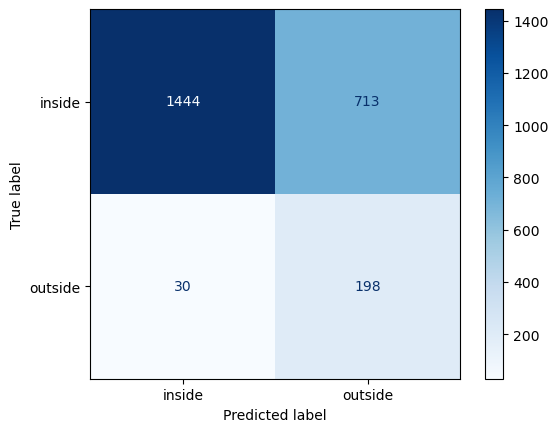

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
df_model_DOV["outlier_pred"] = df_model_DOV.num_missing_features >= threshold_missing_features
df_model_DOV["outlier_pred"] = df_model_DOV.outlier_pred.apply(lambda v: "outside" if v else "inside")        # df_model_DOV["Tg_eval"] = df_model_DOV.apply(lambda row: eval_col_classify(row, "Tg"), axis=1)

var = "Tg"
y_true = df_model_DOV.loc[~df_model_DOV[f"{var}_outlier"].isna(), f"{var}_outlier"]
y_pred = df_model_DOV.loc[~df_model_DOV[f"{var}_outlier"].isna(), "outlier_pred"]

print(balanced_accuracy_score(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=cs)

0.5


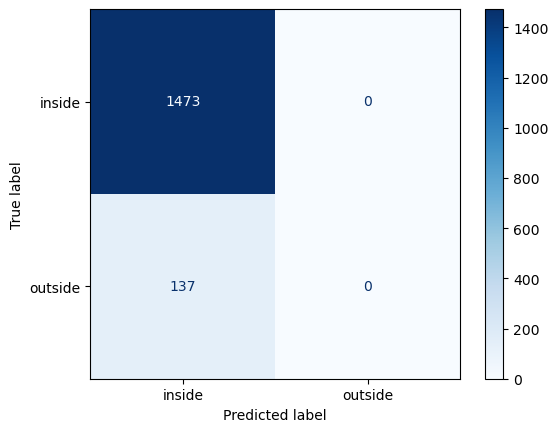

In [16]:
var = "Tm"
y_true = df.loc[~df[f"{var}_outlier"].isna(), f"{var}_outlier"]
y_pred = df.loc[~df[f"{var}_outlier"].isna(), "outlier_pred"]

print(balanced_accuracy_score(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=cs)

In [17]:
keys = [key for key in models_dict.keys()]
i = -1

(0, 64, 0.1)


Text(0, 0.5, 'BA Score')

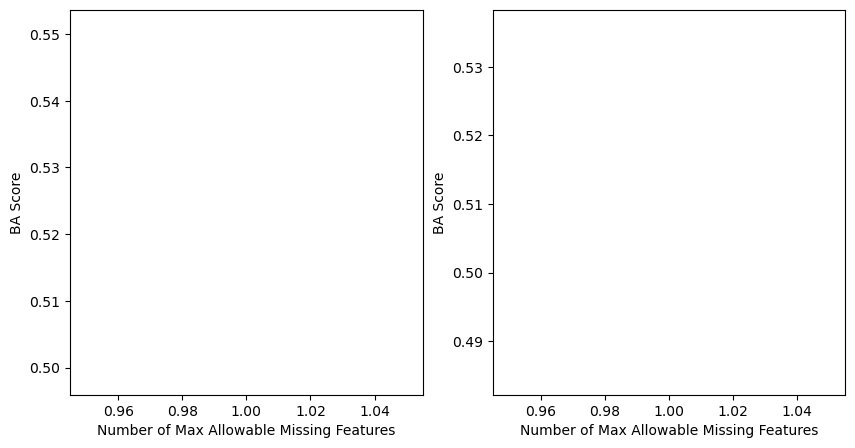

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


i+= 1
key = keys[i]
print(key)
##### Fig 1
ba_tg = models_score_dict[key]["balanced_accuracy"]["Tg"]

x = [i[0] for i in ba_tg]
y = [i[1] for i in ba_tg]

g = sns.lineplot(x=x, y=y, ax=axs[0])

g.set_xlabel("Number of Max Allowable Missing Features")
g.set_ylabel("BA Score")
# g.set_title("Radius = 5 -- nBits = 2048")

##### Fig 2
ba_tm = models_score_dict[key]["balanced_accuracy"]["Tm"]

x = [i[0] for i in ba_tm]
y = [i[1] for i in ba_tm]

g = sns.lineplot(x=x, y=y, ax=axs[1])

g.set_xlabel("Number of Max Allowable Missing Features")
g.set_ylabel("BA Score")
# g.set_title("Radius = 5 -- nBits = 2048")

In [ ]:
4, 2048, 0.05
4, 2048, 0.01

## View Curves

Text(0.5, 1.0, 'Radius = 5 -- nBits = 2048')

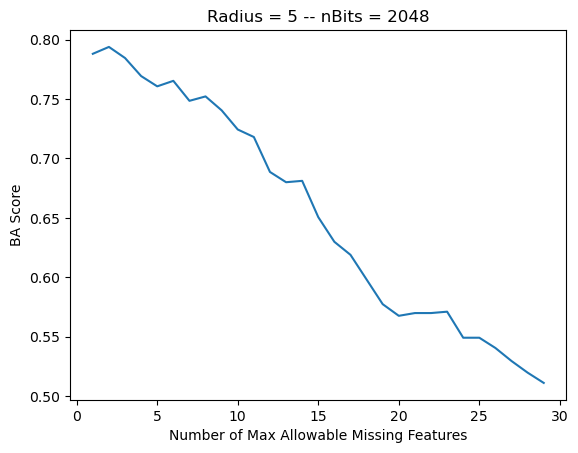

In [30]:
f1_tg = models_score_dict[(3, 2048, 0.1)]["balanced_accuracy"]["Tg"]
x = [i[0] for i in f1_tg]
y = [i[1] for i in f1_tg]

g = sns.lineplot(x=x, y=y)

g.set_xlabel("Number of Max Allowable Missing Features")
g.set_ylabel("BA Score")
g.set_title("Radius = 5 -- nBits = 2048")

Text(0.5, 1.0, 'Radius = 5 -- nBits = 2048')

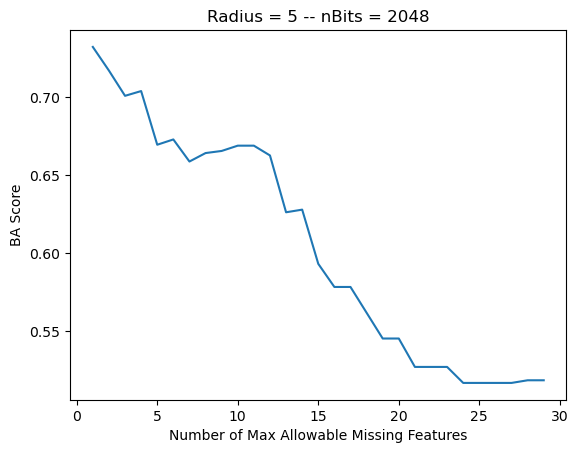

In [29]:
f1_tg = models_score_dict[(3, 2048, 0.1)]["balanced_accuracy"]["Tm"]
x = [i[0] for i in f1_tg]
y = [i[1] for i in f1_tg]

g = sns.lineplot(x=x, y=y)

g.set_xlabel("Number of Max Allowable Missing Features")
g.set_ylabel("BA Score")
g.set_title("Radius = 5 -- nBits = 2048")

# DOV For New Molecules

In [252]:
kfolds_DOV_dict = defaultdict(set)
radius = 4
nBits = 256
dpm = 0.05
for kfold in mm.models:
    kfold_DOV_dict = get_DOV_dict(kfold.df_train, radius=radius, nBits=nBits)
    kfolds_DOV_dict.update(kfold_DOV_dict)

In [253]:
# model_DOV = models_dict[(4, 256, 0.05)]
with open("DOV_4degree_256nBits_05dpm.pk", "wb") as f:
    pk.dump(kfolds_DOV_dict, f)

In [259]:
s = 'COC(=O)[C@@H](C)C[C@@](C)(C[C@@](C)(C[C@](C)(C[C@](C)(C[C@@](C)(C[C@](C)(C[C@@](C)(C[C@@](C)(C[C@](C)(C[C@@](C)(C[C@](C)(C[C@@](C)(C[C@](C)(C[C@@](C)(C[C@](C)(C[C@@](C)(C[C@](C)(C[C@@](C)(C[C@](C)(C[C@@](C)(C[C@@](C)(C[C@@](C)(C[C@@](C)(CC(C)(C)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC)C(=O)OC'
# get_smiles_DOV(smi=s, pm=1, kfold_DOV_dict=model_DOV, radius=4, dpm=0.05)

get_num_missing_features(s, 1, 0.05, kfold_DOV_dict, radius=4, nBits=256)

0

In [ ]:
def get_DOV_dict(df, radius=2, nBits=2048):
    DOV_dict = defaultdict(set)

    for i, row in df.iterrows():
        m = AllChem.MolFromSmiles(row.smiles_polymer)
        fp = AllChem.GetHashedMorganFingerprint(m, radius=radius, nBits=nBits
        )

        for key in fp.GetNonzeroElements():
            DOV_dict[key].add(row.pm)
    
    return DOV_dict

# Generate the DOV for all kfolds into one dataframe and get Scores

In [31]:
kfolds_DOV = pd.DataFrame()
for i, kfold in enumerate(mm.models):
    kfold_DOV = get_kfold_DOV_error(mm.models[i], radius=3, nBits=2048, dpm=.1)
    kfold_DOV["kfold_i"] = i
    
    kfolds_DOV = pd.concat([kfolds_DOV, kfold_DOV])
    
kfolds_DOV["Tm_err"] = abs(kfolds_DOV["Tm_err"])
kfolds_DOV["Tg_err"] = abs(kfolds_DOV["Tg_err"])
kfolds_DOV_grouped = kfolds_DOV.groupby("kfold_i").agg('mean').reset_index()

In [32]:
kfolds_DOV_t = kfolds_DOV[(kfolds_DOV.tg_ae < 1000) | kfolds_DOV.tg_ae.isna()].copy()
kfolds_DOV_t = kfolds_DOV_t[(kfolds_DOV_t.tm_ae < 1000) | kfolds_DOV_t.tm_ae.isna()].copy()
threshold_missing_features = 10

kfolds_DOV["Tg_outlier"] = kfolds_DOV_t.tg_ae >= std_Tg*1.5
kfolds_DOV["Tm_outlier"] = kfolds_DOV_t.tm_ae >= std_Tm*1.5
kfolds_DOV["outlier_pred"] = kfolds_DOV_t.num_missing_features >= threshold_missing_features

In [ ]:
kfolds_DOV["Tg_eval"] = kfolds_DOV.apply(lambda row: eval_col_classify(row, "Tg"), axis=1)
kfolds_DOV["Tm_eval"] = kfolds_DOV.apply(lambda row: eval_col_classify(row, "Tm"), axis=1)

df_to_F1(kfolds_DOV, "Tg"), df_to_F1(kfolds_DOV, "Tm")
df_to_balanced_accuracy(kfolds_DOV, "Tg"), df_to_balanced_accuracy(kfolds_DOV, "Tm")

# Generate DOV Plots

In [33]:
n_missing_DOV = pd.DataFrame()
i_range = [*range(min(kfolds_DOV_t.num_missing_features)+1, max(kfolds_DOV_t.num_missing_features), 1)]
for i in i_range[1:]:
    n_missing_DOV = pd.concat([n_missing_DOV, get_DOV_errs(i, kfolds_DOV_t)])
    
n_missing_DOV = n_missing_DOV.reset_index(drop=True)

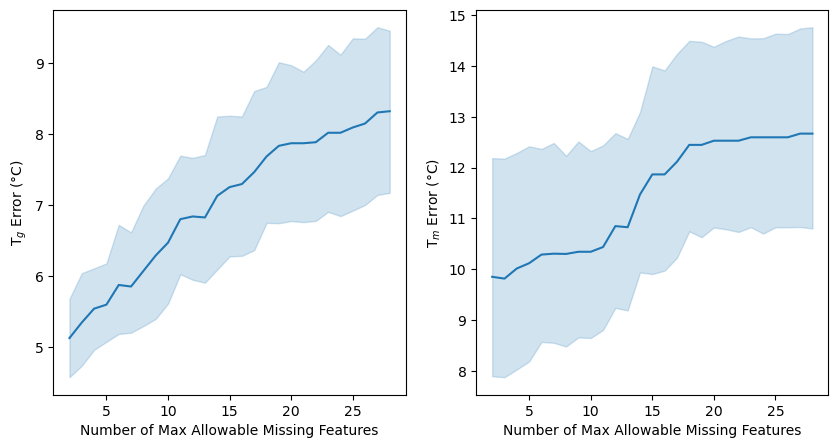

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

g = sns.lineplot(x="lte_missing_features", y="Tm_err", data=n_missing_DOV, ax=ax[1])
g.set_xlabel("Number of Max Allowable Missing Features")
g.set_ylabel("T${_m}$ Error (°C)")

g = sns.lineplot(x="lte_missing_features", y="Tg_err", data=n_missing_DOV, ax=ax[0])
g.set_xlabel("Number of Max Allowable Missing Features")
g.set_ylabel("T${_g}$ Error (°C)")

plt.savefig("Figure_ErrorPlotsDOV.png", dpi=300)

Text(0, 0.5, 'T${_g}$ Error (°C)')

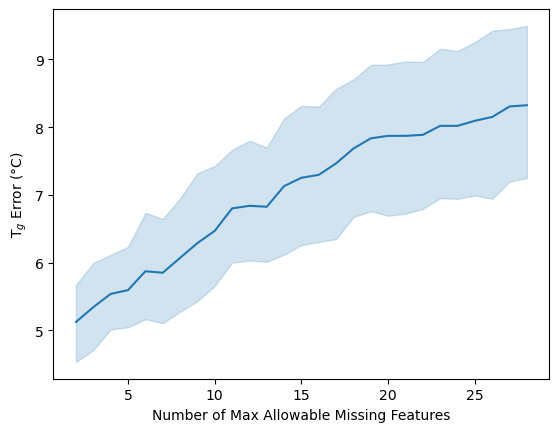

In [35]:
g = sns.lineplot(x="lte_missing_features", y="Tg_err", data=n_missing_DOV)
g.set_xlabel("Number of Max Allowable Missing Features")
g.set_ylabel("T${_g}$ Error (°C)")